In [1]:
#Importing the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Making connection to MySQL
conn = pymysql.connect(
    host = 'localhost', 
    user = 'db_user',
    password = 'db_password',
    database = 'your_db'
)

In [3]:
#Importing the data
df_applicant = pd.read_sql("SELECT * FROM applicant_info", conn)
df_financial = pd.read_sql("SELECT * FROM financial_info", conn)
df_loan = pd.read_sql("SELECT * FROM loan_info", conn)

In [4]:
#Getting an idea about the data
df_applicant.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed
0,LP001002,Male,No,0,Graduate,No
1,LP001003,Male,Yes,1,Graduate,No
2,LP001005,Male,Yes,0,Graduate,Yes
3,LP001006,Male,Yes,0,Not Graduate,No
4,LP001008,Male,No,0,Graduate,No


In [5]:
#Getting an idea about the data
df_financial.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,LP001002,5849.0,0.0,NaN,360.0,1.0
1,LP001003,4583.0,1508.0,128.0,360.0,1.0
2,LP001005,3000.0,0.0,66.0,360.0,1.0
3,LP001006,2583.0,2358.0,120.0,360.0,1.0
4,LP001008,6000.0,0.0,141.0,360.0,1.0


In [6]:
#Getting an idea about the data
df_loan.head()

,Loan_ID,Property_Area,Loan_Status
0,LP001002,Urban,Y
1,LP001003,Rural,N
2,LP001005,Urban,Y
3,LP001006,Urban,Y
4,LP001008,Urban,Y


In [7]:
conn.close()

In [8]:
df = df_applicant.merge(df_financial , on = 'Loan_ID',how = 'inner')
df = df.merge(df_loan , on = 'Loan_ID' , how = 'inner')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y


In [9]:
# Getting an idea about the duplicate rows in the dataset
df.duplicated().sum()

np.int64(0)

In [10]:
# Getting an idea about the NULL values in the dataset 
df.isnull().sum().any()

np.True_

In [11]:
# Getting an idea about the shape of the data
print('Shape :', df.shape)
print('Rows :', df.shape[0])
print('Columns :', df.shape[1])

Shape : (614, 13)
Rows : 614
Columns : 13


In [12]:
# Getting an idea about column wise sum of NULL values
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
# Dealing with NULL values 
for col in df.columns:
    if df[col].dtype in [np.int64, np.float64]:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

In [14]:
# Getting an idea about column wise sum of NULL values
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [15]:
# Getting an idea whether there are any missing values in the data
df.isnull().sum().any()

np.False_

In [16]:
# Dealing with categorical columns 
cat_cols = df.select_dtypes(include = ['object']).columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = df[col].astype(str) 
    df[col] = le.fit_transform(df[col])

In [17]:
# Getting an idea about the dtypes 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    int64  
 1   Gender             614 non-null    int64  
 2   Married            614 non-null    int64  
 3   Dependents         614 non-null    int64  
 4   Education          614 non-null    int64  
 5   Self_Employed      614 non-null    int64  
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    int64  
 12  Loan_Status        614 non-null    int64  
dtypes: float64(5), int64(8)
memory usage: 62.5 KB


In [18]:
# Getting the proportion of values in Loan_Status
df['Loan_Status'].value_counts()

Loan_Status
1    422
0    192
Name: count, dtype: int64

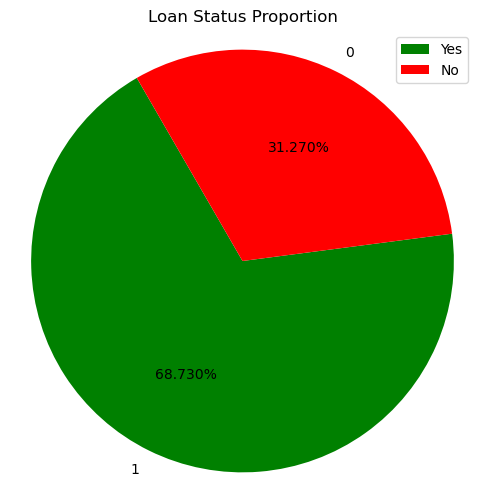

In [19]:
# Pie Chart for the proportion of Loan Status 
plt.figure(figsize=(6,6))
status_counts = df['Loan_Status'].value_counts()
plt.pie(
    status_counts, 
    labels=status_counts.index, 
    autopct='%.3f%%', 
    startangle=120, 
    colors=['Green', 'Red']  # Green for 0, Red for 1
)
plt.title("Loan Status Proportion")
plt.axis('equal')  # Equal aspect ratio for a perfect circle
plt.legend(['Yes', 'No'])
plt.show()

In [20]:
# Getting the proportion of values in Loan_Status
df['Gender'].value_counts()

Gender
1    502
0    112
Name: count, dtype: int64

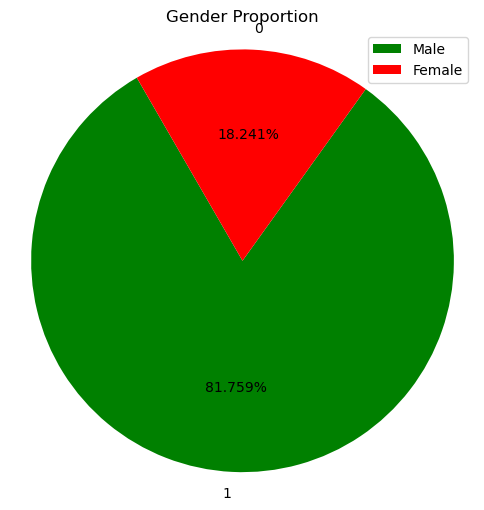

In [21]:
# Pie Chart for the proportion of Gender
plt.figure(figsize=(6,6))
gender_counts = df['Gender'].value_counts()
plt.pie(
    gender_counts, 
    labels=gender_counts.index, 
    autopct='%.3f%%', 
    startangle=120, 
    colors=['Green', 'Red']  # Green for 0, Red for 1
)
plt.title("Gender Proportion")
plt.axis('equal')  # Equal aspect ratio for a perfect circle
plt.legend(['Male', 'Female'])
plt.show()

In [22]:
# Getting the proportion of values in Loan_Status
df['Married'].value_counts()

Married
1    401
0    213
Name: count, dtype: int64

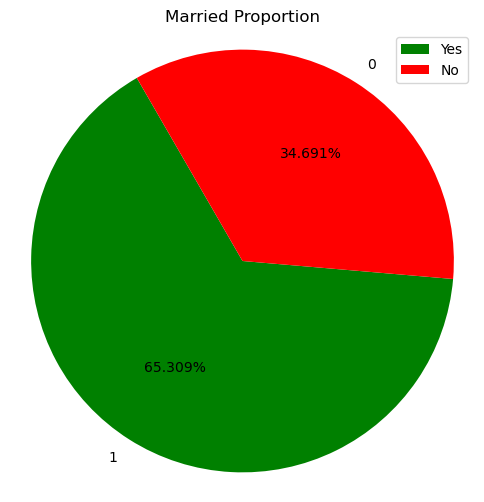

In [23]:
# Pie Chart for the proportion of Married Status
plt.figure(figsize=(6,6))
married_counts = df['Married'].value_counts()
plt.pie(
    married_counts, 
    labels=married_counts.index, 
    autopct='%.3f%%', 
    startangle=120, 
    colors=['Green', 'Red']  # Green for 0, Red for 1
)
plt.title("Married Proportion")
plt.axis('equal')  # Equal aspect ratio for a perfect circle
plt.legend(['Yes', 'No'])
plt.show()

In [24]:
# Getting the proportion of values in Education
df['Education'].value_counts()

Education
0    480
1    134
Name: count, dtype: int64

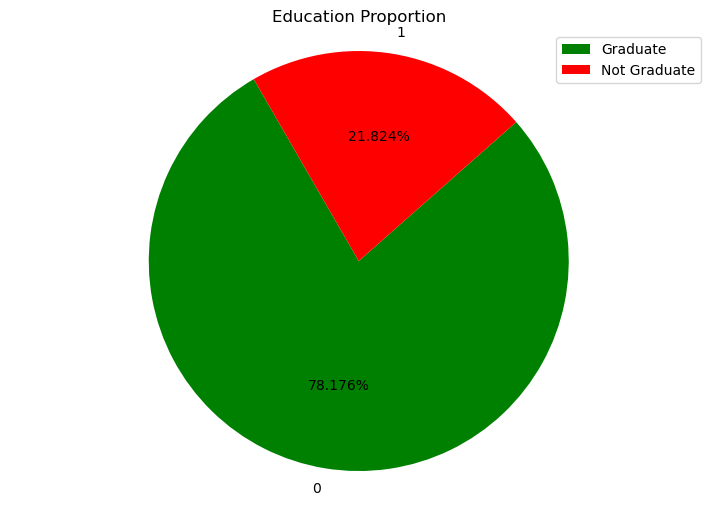

In [25]:
# Pie Chart for the proportion of Education Level
plt.figure(figsize=(9,6))
education_counts = df['Education'].value_counts()
plt.pie(
    education_counts, 
    labels=education_counts.index, 
    autopct='%.3f%%', 
    startangle=120, 
    colors=['Green', 'Red']  # Green for 0, Red for 1
)
plt.title("Education Proportion")
plt.axis('equal')  # Equal aspect ratio for a perfect circle
plt.legend(['Graduate', 'Not Graduate'])
plt.show()

In [26]:
# Getting the proportion of values in Self_Employed
df['Self_Employed'].value_counts()

Self_Employed
0    532
1     82
Name: count, dtype: int64

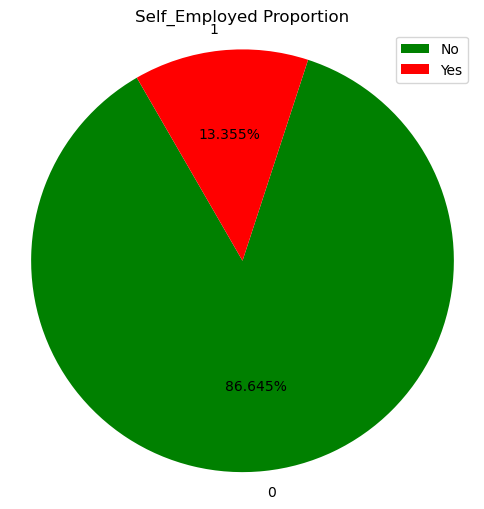

In [27]:
# Pie Chart for the proportion of Self_Employed
plt.figure(figsize=(6,6))
self_employed_counts = df['Self_Employed'].value_counts()
plt.pie(
    self_employed_counts, 
    labels=self_employed_counts.index, 
    autopct='%.3f%%', 
    startangle=120, 
    colors=['Green', 'Red']  # Green for 0, Red for 1
)
plt.title("Self_Employed Proportion")
plt.axis('equal')  # Equal aspect ratio for a perfect circle
plt.legend(['No', 'Yes'])
plt.show()

In [28]:
# Example: if already loaded as df_applicant, df_financial, df_loan
df = df_applicant.merge(df_financial, on='Loan_ID').merge(df_loan, on='Loan_ID')


In [29]:
# Initialize label_encoders dictionary (THIS WAS MISSING!)
label_encoders = {}


In [30]:
# Identify categorical columns (adjust based on your actual columns)
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
# Only use columns that exist in your dataframe
categorical_columns = [col for col in categorical_columns if col in df.columns]
print(f"Categorical columns to encode: {categorical_columns}")

Categorical columns to encode: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [31]:
# Encode categorical variables
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Store the encoder
    print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")


Encoded Gender: {'Female': np.int64(0), 'Male': np.int64(1), 'None': np.int64(2)}
Encoded Married: {'No': np.int64(0), 'None': np.int64(1), 'Yes': np.int64(2)}
Encoded Dependents: {'0': np.int64(0), '1': np.int64(1), '2': np.int64(2), '3+': np.int64(3), 'None': np.int64(4)}
Encoded Education: {'Graduate': np.int64(0), 'Not Graduate': np.int64(1)}
Encoded Self_Employed: {'No': np.int64(0), 'None': np.int64(1), 'Yes': np.int64(2)}
Encoded Property_Area: {'Rural': np.int64(0), 'Semiurban': np.int64(1), 'Urban': np.int64(2)}


In [32]:
# Prepare features and target
# Adjust these column names based on your actual data
X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)  # Features
y = df['Loan_Status']  # Target


In [33]:
print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")


Features shape: (614, 11)
Target distribution:
Loan_Status
Y    422
N    192
Name: count, dtype: int64


In [34]:
# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"Target classes: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")


Target classes: {'N': np.int64(0), 'Y': np.int64(1)}


In [35]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [36]:
print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (491, 11)
Test set: (123, 11)


In [37]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
print("Features scaled successfully!")

Features scaled successfully!


In [39]:
# Train model
print("\n=== Model Training ===")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)


=== Model Training ===


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [40]:
# Evaluate model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

In [41]:
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

Accuracy: 0.8455

Confusion Matrix:
[[23 15]
 [ 4 81]]

Classification Report:
              precision    recall  f1-score   support

           N       0.85      0.61      0.71        38
           Y       0.84      0.95      0.90        85

    accuracy                           0.85       123
   macro avg       0.85      0.78      0.80       123
weighted avg       0.85      0.85      0.84       123



In [42]:
# Save the model with ALL required components
with open("loan_prediction.pkl", "wb") as f:
    pickle.dump((model, scaler, label_encoders, le_target), f)

In [43]:
print("✅ Model saved successfully as 'loan_approval.pkl'")
print("Saved components:")
print("1. Model (RandomForestClassifier)")
print("2. Scaler (StandardScaler)")
print("3. Label Encoders (for categorical features)")
print("4. Target Encoder (for loan status)")

✅ Model saved successfully as 'loan_approval.pkl'
Saved components:
1. Model (RandomForestClassifier)
2. Scaler (StandardScaler)
3. Label Encoders (for categorical features)
4. Target Encoder (for loan status)


In [44]:
# Verify the saved file
print("\n=== Verifying Saved File ===")
with open("loan_prediction.pkl", "rb") as f:
    loaded_objects = pickle.load(f)


=== Verifying Saved File ===


In [45]:
print(f"Number of objects in pickle: {len(loaded_objects)}")
for i, obj in enumerate(loaded_objects):
    print(f"Object {i}: {type(obj)}")

Number of objects in pickle: 4
Object 0: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Object 1: <class 'sklearn.preprocessing._data.StandardScaler'>
Object 2: <class 'dict'>
Object 3: <class 'sklearn.preprocessing._label.LabelEncoder'>


In [46]:
# Show feature names for reference
print(f"\nFeature names: {X.columns.tolist()}")


Feature names: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']


In [47]:
print("=== FINAL VERIFICATION ===")

# Load the model
with open("loan_prediction.pkl", "rb") as f:
    model, scaler, encoders, target_encoder = pickle.load(f)

print("✅ All objects loaded successfully!")
print(f"Model type: {type(model)}")
print(f"Scaler type: {type(scaler)}")
print(f"Number of encoders: {len(encoders)}")
print(f"Encoder keys: {list(encoders.keys())}")
print(f"Target encoder classes: {target_encoder.classes_}")


=== FINAL VERIFICATION ===
✅ All objects loaded successfully!
Model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Scaler type: <class 'sklearn.preprocessing._data.StandardScaler'>
Number of encoders: 6
Encoder keys: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
Target encoder classes: ['N' 'Y']


In [48]:
# Test with sample data that matches your training
print("\n=== TESTING PREDICTION ===")
sample_data = {
    'Gender': ['Male'],
    'Married': ['Yes'], 
    'Dependents': ['0'],
    'Education': ['Graduate'],
    'Self_Employed': ['No'],
    'ApplicantIncome': [50000],
    'CoapplicantIncome': [2000],
    'LoanAmount': [15000],
    'Loan_Amount_Term': [24],
    'Credit_History': [1.0],
    'Property_Area': ['Urban']
}

sample_df = pd.DataFrame(sample_data)
print("Sample input data:")
print(sample_df)



=== TESTING PREDICTION ===
Sample input data:
  Gender Married Dependents Education Self_Employed  ApplicantIncome  \
0   Male     Yes          0  Graduate            No            50000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0               2000       15000                24             1.0   

  Property_Area  
0         Urban  


In [49]:
# Preprocess sample data exactly like training
for column in encoders:
    if column in sample_df.columns:
        sample_df[column] = encoders[column].transform(sample_df[column])

print("\nEncoded data:")
print(sample_df)


Encoded data:
   Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0       1        2           0          0              0            50000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0               2000       15000                24             1.0   

   Property_Area  
0              2  


In [50]:
# Scale features
sample_scaled = scaler.transform(sample_df)


In [51]:
# Make prediction
prediction = model.predict(sample_scaled)
prediction_proba = model.predict_proba(sample_scaled)

In [52]:
# Convert back to original label
result = target_encoder.inverse_transform(prediction)
probability = prediction_proba[0][prediction[0]]
print(f"\n🎯 Prediction Result: {result[0]} (confidence: {probability:.2%})")
print("✅ Model is working perfectly!")


🎯 Prediction Result: Y (confidence: 72.00%)
✅ Model is working perfectly!
